In [290]:
import numpy as np
import time
from halotools.utils.vector_utilities import angles_between_list_of_vectors
import matplotlib.pyplot as plt

from ellipsoidal_nfw import random_nfw_ellipsoid

# This is not installed!!! Right now, these files are just sitting in the same directory
import inertia_tensors as itens

In [259]:
def downsample_halo(halo, remaining_portion):
    """
    Assuming the halo is a numpy array of (x,y,z) coordinates, return a subset of that list with a portion taken out
    
    Params:
        halo                    - numpy array of (x,y,z) coordinates representing the dark matter particle locations
        remaining_portion       - Fraction of the total halo to keep (0.8 returns 80% of the passed in halo)
    Returns:
        downsampled             - The portion of the halo remaining
    """
    num_els = int( len(halo)*remaining_portion )
    inds = np.random.choice( np.arange(len(halo)), num_els, replace=False)
    return halo[inds]

def calculate_axes(halos):
    """
    Given a downsampled halo (or several halos), calculate a major axis using the inertia tensor
    
    Params:
        halos                   - Single halo or list of several halos where each halo is a list of (x,y,z) tuples representing cooridnates
        separate_axes           - By default, inertia_tensors returns a 6-tuple where each element is an array
                                  The first three arrays hold the major, intermediate, and minor axes
                                  The last three hold the eigenvectors
                                  Setting this to True (it's default value) will separate the axes and eigenvectors into separate arrays
    Returns:
        results                 - The 6-tuple of axes and eigenvectors (each tuple element is an array representing one property)
                                  Each array in the tuple holds a value for every inertia tensor
    """
    I = itens.iterative_inertia_tensors_3D(halos)
    return itens._principal_axes_3D(I)

def separate_axes(principal_axes):
    """
    Splits the results of calculate_axes into easier to parse arrays
    
    Params:
        principal_axes          - The 6-tuple returned by inertia_tensors._principal_axes
    
    Returns:
        axis_lengths            - an nx3 numpy array where each row is a new object and the three columns are the major, intermediate, and minor axis lengths
        evecs                   - an nx3x3 array where the first index is the object, then each of the three columns is an eigenvector for that object
    """
    axis_lengths = np.array( [ principal_axes[0], principal_axes[1], principal_axes[2] ] ).T
    evecs = np.array( [ principal_axes[3].T, principal_axes[4].T, principal_axes[5].T ] ).T
    
    return axis_lengths, evecs

def get_angles(evecs_A, evecs_B, ignore_antiparallel=True):
    """
    Simply calls angles_between_list_of_vectors between just the major eigenvectors of each set given
    
    Params:
        evecs_A                 - The list of eigenvectors from one system (multiple objects each with their given eigenvectors)
        evecs_B                 - The list of eigenvectors from the second system
        ignore_antiparallel     - if pi is the same as 0 in terms of misalignment, take the min of angle and np.pi-angle for each angle
    
    Returns:
        angles                  - The angles between each major eigenvector in evecs_A and the corresponding major eigenvector in evecs_B
    """
    
    # Get just the major eigenvectors for each sample
    major_A = evecs_A[:,:,0]
    major_B = evecs_B[:,:,0]
    
    angles = angles_between_list_of_vectors(major_A, major_B)
    
    if ignore_antiparallel:
        # If antiparallel is the same as parallel, just report the smaller angle
        angles = np.minimum( angles, np.pi-angles )
    
    return angles

# Get theta and phi from the eigenvector (with respect to the z axis)
def theta_phi(coords):
    r = np.sqrt( np.sum( coords**2, axis=1 ) )
    units = coords/np.array([r,r,r]).T
    thetas = np.arccos( units[:,2] )
    phis = np.arccos( units[:,0]/np.sin(thetas) )
    return thetas, phis

In [202]:
npts = 5000
conc = np.zeros(npts)+5.
x, y, z = random_nfw_ellipsoid(conc, a=0.4, b=0.5, c=1)
coords = np.array( [ coord for coord in zip(x,y,z) ] )

In [292]:
# Run for a single value of npts

repetitions = 1000
frac = 0.8
npts = 100

perfect_axes = np.array( [ np.array([0,0,1]) for i in range(repetitions) ] )
#coords_A = np.array( [coords for i in range(repetitions) ] )

coords_A = []
coords_B = []
for i in range(repetitions):
    #npts = 500000
    conc = np.zeros(npts)+5.
    x, y, z = random_nfw_ellipsoid(conc, a=0.5, b=0.5, c=1)
    coords = np.array( [ coord for coord in zip(x,y,z) ] )
    coords_A.append( coords )
    coords_B.append( downsample_halo(coords, frac) )
coords_A = np.array(coords_A)
coords_B = np.array(coords_B)
lengths_A, evecs_A = separate_axes( calculate_axes(coords_A) )
lengths_B, evecs_B = separate_axes( calculate_axes(coords_B) )

In [280]:
# OR run for multiple resolutions

runs = 4
repetitions = 1000
frac = 0.8
npts = 10
calculate_every = 100

realizations = []
resolutions = []
angles = []

#perfect_axes = np.array( [ np.array([0,0,1]) for i in range(repetitions) ] )
#coords_A = np.array( [coords for i in range(repetitions) ] )

for i in range(runs):
    print(i)
    coords_A = []
    coords_B = []
    ang = []
    for i in range(repetitions):
        conc = np.zeros(npts)+5.
        x, y, z = random_nfw_ellipsoid(conc, a=0.5, b=0.5, c=1)
        coords = np.array( [ coord for coord in zip(x,y,z) ] )
        coords_A.append( coords )
        #coords_B.append( downsample_halo(coords, frac) )
        
        # To save on space, calculate the angles every so often and erase the saved lists of coordinates
        if (i%calculate_every == 0 and i != 0) or i == repetitions-1:
            coords_A = np.array(coords_A)
            #coords_B = np.array(coords_B)
            lengths_A, evecs_A = separate_axes( calculate_axes(coords_A) )
            #lengths_B, evecs_B = separate_axes( calculate_axes(coords_B) )
            perfect_axes = np.array( [ np.array([0,0,1]) for i in range(len(coords_A)) ] )
            hold = angles_between_list_of_vectors( perfect_axes, evecs_A[:,:,0] )
            ang.append( hold )
            
            # Clear the saved coordinates
            coords_A = []
            #coords_B = []
    
    #realizations.append( evecs_A[:,:,0] )
    resolutions.append( npts )
    npts *= 10
    
    angles.append( np.hstack(ang) )
    
for i in range(len(angles)):
    angles[i] = np.minimum( angles[i], np.pi-angles[i] )
    
mean_angles = np.mean(angles, axis=1)

0
1
2
3


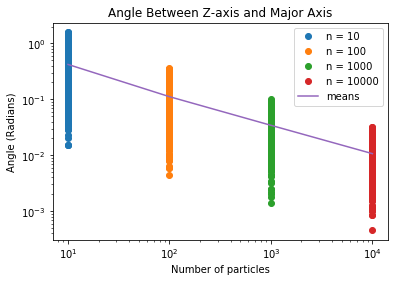

In [294]:
for i in range(len(angles)):
    plt.plot( np.ones(len(angles[i]))*resolutions[i], angles[i], "o", label="n = "+str(resolutions[i]) )
plt.plot(resolutions, mean_angles, label="means")
plt.legend()
plt.title("Angle Between Z-axis and Major Axis")
plt.xlabel("Number of particles")
plt.ylabel("Angle (Radians)")
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, 'Count')

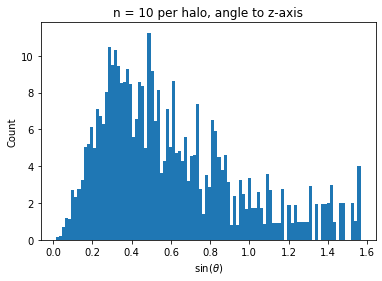

In [296]:
#perfect_angles = sorted(perfect_angles)
plt.hist(angles[0],bins=100,weights=np.sin(angles[0]));
plt.title("n = 10 per halo, angle to z-axis")
plt.xlabel(r"sin($\theta$)")
plt.ylabel("Count")
#plt.hist(thetas)

Text(0, 0.5, 'Count')

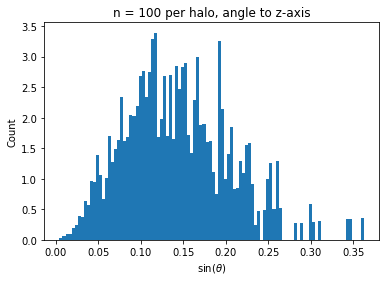

In [295]:
#perfect_angles = sorted(perfect_angles)
plt.hist(angles[1],bins=100,weights=np.sin(angles[1]));
plt.title("n = 100 per halo, angle to z-axis")
plt.xlabel(r"sin($\theta$)")
plt.ylabel("Count")
#plt.hist(thetas)

Text(0, 0.5, 'Count')

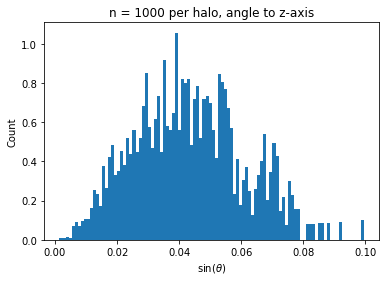

In [297]:
#perfect_angles = sorted(perfect_angles)
plt.hist(angles[2],bins=100,weights=np.sin(angles[2]));
plt.title("n = 1000 per halo, angle to z-axis")
plt.xlabel(r"sin($\theta$)")
plt.ylabel("Count")
#plt.hist(thetas)

Text(0, 0.5, 'Count')

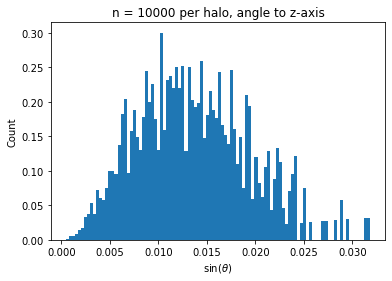

In [298]:
#perfect_angles = sorted(perfect_angles)
plt.hist(angles[3],bins=100,weights=np.sin(angles[3]));
plt.title("n = 10000 per halo, angle to z-axis")
plt.xlabel(r"sin($\theta$)")
plt.ylabel("Count")
#plt.hist(thetas)

In [289]:
import gc
gc.collect()

37027